In [2]:
from os import path as op
import sys
import numpy as np
import mne
import autoreject

from library import config, helpers

In [26]:
def clean_with_ar_local(data_, n_jobs=config.n_jobs):
    picks = mne.pick_types(data_.info, meg=False, eeg=True, stim=False,
                       eog=False)
    ar = autoreject.AutoReject(n_interpolate=np.array([2,8,16]), 
                               consensus= np.linspace(0.3, 1.0, 8),
                               picks=picks, 
                               n_jobs=n_jobs,
                               random_state = 42,
                               verbose='tqdm')
    epo_clean, reject_log = ar.fit_transform(data_, return_log=True)
    return epo_clean, ar, reject_log


def get_ica_weights(subID, data_, ica_from_disc = False, reject=None,
                    method='picard', fit_params=None, picks=None, save_to_disc=True):
    ### Load ICA data (after comp rejection)?
    if ica_from_disc:
        ica = mne.preprocessing.read_ica(fname=op.join(path_outp_ICA, subID + '-ica.fif'))
    else:
        data_.drop_bad(reject=reject)
        ica = mne.preprocessing.ICA(method=method, 
                                    fit_params=fit_params)
        ica.fit(data_)
        if save_to_disc:
            ica.save(fname=op.join(config.paths['03_preproc-ica'], subID + '-ica.fif'),
                     overwrite=True)
    return ica


## Reject components:
# Via correlation w/ EOG channels:
def rej_ica_eog(subID, data_ica_, data_raw_, data_forica_, data_to_clean_):
    """
    Find EOG components, remove them, and apply ICA weights to full data.
    """
    EOGexclude = []
    
    epochs_eog    = mne.preprocessing.create_eog_epochs(raw = data_raw_, ch_name = 'VEOG')
    eog_indices, eog_scores = data_ica_.find_bads_eog(data_forica_)  #, threshold=2)
        #EOGexclude.extend(np.argsort(eog_scores)[-2:])

    #    data_ica_.plot_scores(eog_scores)

    ## Plot marked components:
    # data_ica_.plot_components(inst=data_forica_, picks=EOGexclude)
    
    data_ica_.exclude = eog_indices[:2]
    # overwrite on disk with updated version:
    data_ica_.save(fname=op.join(path_outp_ICA, subID + '-ica.fif.'))
    # and kick out components:
    data_clean_ = data_ica_.apply(data_to_clean_.copy())
    return data_clean_

In [18]:
# parse args:
if (len(sys.argv) > 1) and isinstance(sys.argv[1], int):
    helpers.print_msg('Running Job Nr. ' + sys.argv[1])
    job_nr = int(float(sys.argv[1]))
else:
    job_nr = None

## Full procedure:
sub_list = np.setdiff1d(np.arange(1,config.n_subjects_total+1), config.ids_missing_subjects)
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

if job_nr is not None:
    sub_list_str = [sub_list_str[job_nr]]

## to run a single subject, modify and uncomment one of the following lines:
sub_list_str = ['VME_S20']


In [7]:
subID = 'VME_S20'
data_raw_ = helpers.load_data(subID + '-prepared',
                                    config.paths['01_prepared'],
                                    append='-raw').load_data()
data_forICA = helpers.load_data(subID + '-stimon',
                                    config.paths['02_epochs'],
                                    append='-epo')

Opening raw data file /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/01_prepared/VME_S20-prepared-raw.fif...
    Range : 0 ... 4625979 =      0.000 ...  9251.958 secs
Ready.
Reading 0 ... 4625979  =      0.000 ...  9251.958 secs...
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/02_epochs/VME_S20-stimon-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    2300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
720 matching events found
No baseline correction applied
0 projection items activated


In [8]:
epochs_eog    = mne.preprocessing.create_eog_epochs(raw = data_forICA, ch_name = 'VEOG')


Using EOG channel: VEOG
EOG channel index for this subject is: [65]


TypeError: get_data() got an unexpected keyword argument 'reject_by_annotation'

In [20]:


for idx, subID in enumerate(sub_list_str):
    helpers.print_msg('Processing subject ' + subID + '.')
    # get BP [1; 40Hz] filtered data to train ICA:
    data_forICA = helpers.load_data(subID + '-stimon',
                                    config.paths['02_epochs'],
                                    append='-epo')
    
    # clean it with autoreject local:
    data_forAR = data_forICA.copy().apply_baseline((-0.4,0)) # AR does not perform well on non-baseline corrected data
    _, ar, reject_log = clean_with_ar_local(data_forica)
    
    # apply the AR corrections to the non-baselined data:
    data_forICA_clean = ar.transform(data_forICA)
    
    # fit ICA to cleaned data:
    data_ica = get_ica_weights(subID, data_forICA_clean, ica_from_disc=False)
    
    # remove eog components and project to actual data:
    data_stimon = rej_ica_eog(subsub, data_ica, data_forica_c, data_stimon)
    
    
    data_forica_c, ar, reject_log = clean_with_ar_local(data_forica, n_jobs=18)
    
#     ica_raw = get_ica_weights(subID,
#                           data_forica,
#                           #method='infomax',
#                           #fit_params={'extended':True},
#                           save_to_disc=False)
    


###############################################
Processing subject VME_S20.
###############################################

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/02_epochs/VME_S20-stimon-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    2300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
720 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/720 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/720 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/720 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/720 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=16


  0%|          | Repairing epochs : 0/720 [00:00<?,       ?it/s]

Dropped 17 epochs: 444, 445, 500, 501, 502, 503, 573, 574, 643, 644, 645, 646, 647, 716, 717, 718, 719


In [33]:
data_forica = helpers.load_data(subID + '-stimon',
                                    config.paths['02_epochs'],
                                    append='-epo')
ica_raw = get_ica_weights(subID,
                          data_forica_c,
                          #method='infomax',
                          #fit_params={'extended':True},
                          picks=['eeg'],
                          save_to_disc=True)


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/02_epochs/VME_S20-stimon-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    2300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
720 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Fitting ICA to data using 60 channels (please be patient, this may take a while)


/tmp/ipykernel_102621/1473806658.py:22: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data_)


Selecting by non-zero PCA components: 60 components
Fitting ICA took 117.7s.
Overwriting existing file.
Writing ICA solution to /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc-ica/VME_S20-ica.fif...


In [30]:
ransac.fit(data_forica)

Iterating epochs ...


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    7.6s remaining:   32.9s
[Parallel(n_jobs=16)]: Done   5 out of  16 | elapsed:    7.7s remaining:   17.0s
[Parallel(n_jobs=16)]: Done   7 out of  16 | elapsed:    7.8s remaining:   10.0s
[Parallel(n_jobs=16)]: Done   9 out of  16 | elapsed:    7.8s remaining:    6.0s
[Parallel(n_jobs=16)]: Done  11 out of  16 | elapsed:    7.8s remaining:    3.5s


[Done]


[Parallel(n_jobs=16)]: Done  13 out of  16 | elapsed:    7.8s remaining:    1.8s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    7.9s finished


In [32]:
ransac.bad_chs_

['Fp1']

In [60]:
data_forica.copy().apply_baseline((None,None))

Applying baseline correction (mode: mean)


Number of events,720
Events,Stimulus/S150: 30Stimulus/S151: 30Stimulus/S152: 30Stimulus/S153: 30Stimulus/S154: 30Stimulus/S155: 30Stimulus/S156: 30Stimulus/S157: 30Stimulus/S158: 30Stimulus/S159: 30Stimulus/S160: 30Stimulus/S161: 30Stimulus/S162: 30Stimulus/S163: 30Stimulus/S164: 30Stimulus/S165: 30Stimulus/S166: 30Stimulus/S167: 30Stimulus/S168: 30Stimulus/S169: 30Stimulus/S170: 30Stimulus/S171: 30Stimulus/S172: 30Stimulus/S173: 30
Time range,-0.600 – 2.300 sec
Baseline,-0.600 – 2.300 sec


In [23]:
%matplotlib qt
ica.plot_properties(data_forica)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
720 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
720 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
720 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
720 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
720 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [45]:
ica_raw.plot_components()

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>]

Not setting metadata
Not setting metadata
720 matching events found


/tmp/ipykernel_45824/651052546.py:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  ica_raw.plot_sources(data_forica)


No baseline correction applied
0 projection items activated
0 bad epochs dropped


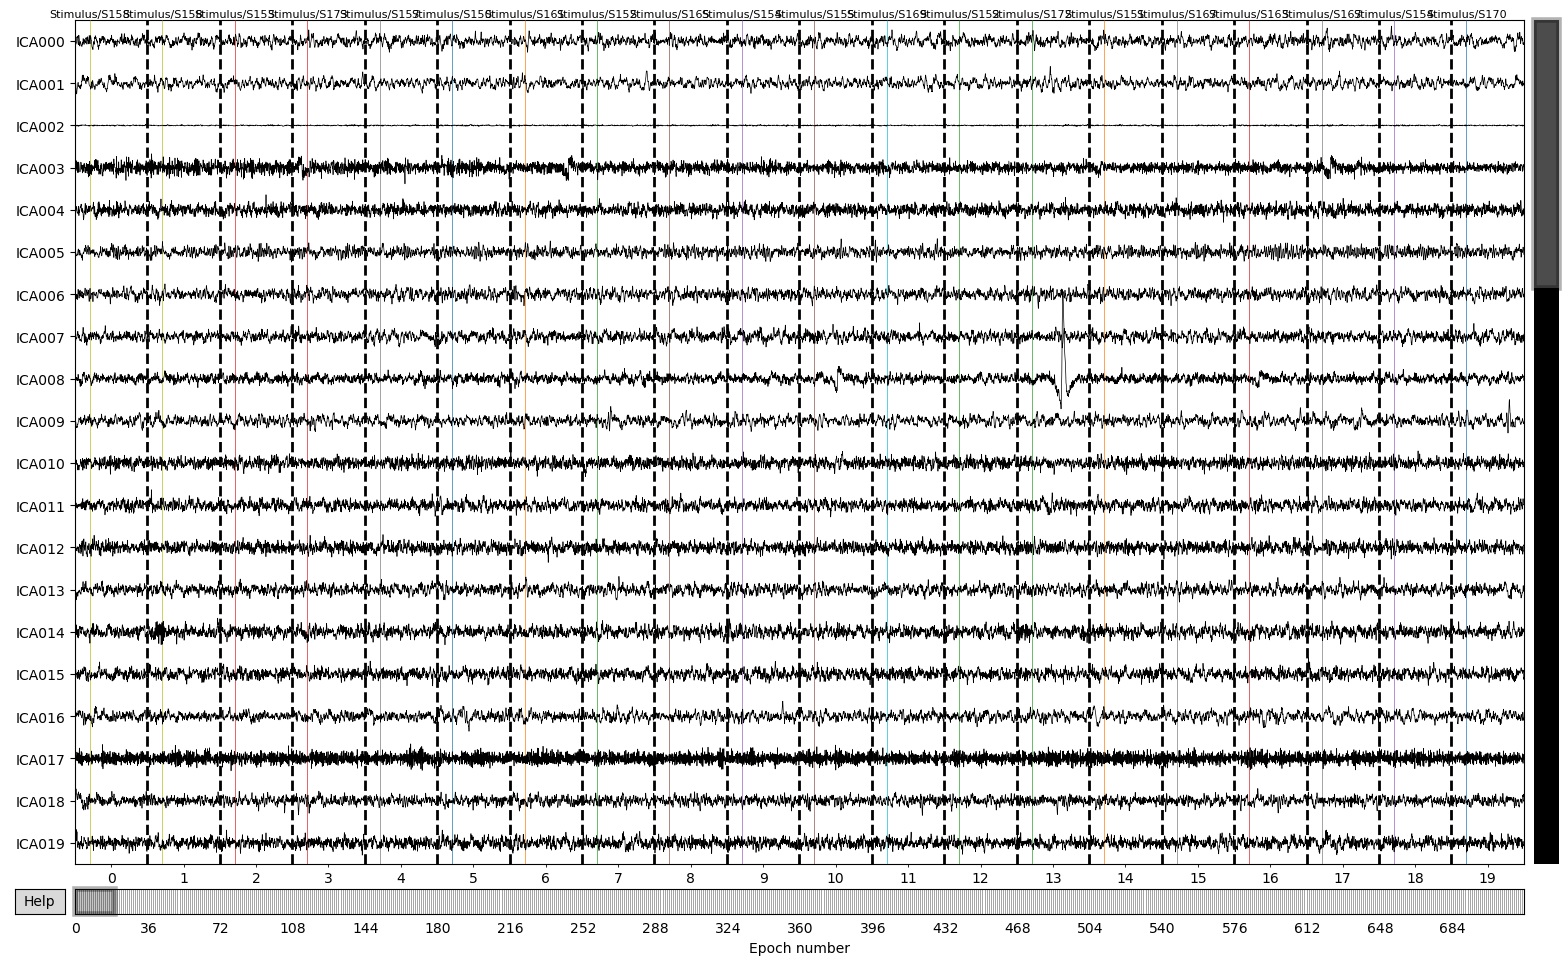

Traceback (most recent call last):
  File "/u/fklotzsche/conda-envs/mne/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/u/fklotzsche/conda-envs/mne/lib/python3.9/site-packages/mne/viz/_figure.py", line 405, in _close
    self.mne.ica.exclude = [self.mne.ica._ica_names.index(ch)
  File "/u/fklotzsche/conda-envs/mne/lib/python3.9/site-packages/mne/viz/_figure.py", line 405, in <listcomp>
    self.mne.ica.exclude = [self.mne.ica._ica_names.index(ch)
ValueError: 'ECG' is not in list


In [36]:
ica_raw.plot_sources(data_forica)